In [2]:
%matplotlib inline
%load_ext rpy2.ipython

import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_context('notebook', font_scale=1.5)

In [3]:
import bokeh
from bokeh.plotting import show
bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
import flowkit as fk

## Raw data

In [6]:
fcs_path = '../data/AMJ_5L_Costim.fcs'
sample = fk.Sample(fcs_path)

### Metadata

In [7]:
sample.channels

{'1': {'PnN': 'FSC-A'},
 '2': {'PnN': 'FSC-H'},
 '3': {'PnN': 'FSC-W'},
 '4': {'PnN': 'SSC-A'},
 '5': {'PnN': 'SSC-H'},
 '6': {'PnN': 'SSC-W'},
 '7': {'PnN': 'Blue B-A', 'PnS': 'CD57 FITC'},
 '8': {'PnN': 'Blue A-A', 'PnS': 'CD4 PerCP Cy55'},
 '9': {'PnN': 'Violet H-A', 'PnS': 'CD14 CD19 vAmine'},
 '10': {'PnN': 'Violet G-A', 'PnS': 'CD3 AmCyan'},
 '11': {'PnN': 'Red C-A', 'PnS': 'CD27 APC'},
 '12': {'PnN': 'Red B-A', 'PnS': 'TNFa A700'},
 '13': {'PnN': 'Red A-A', 'PnS': 'CD8 APC Cy7'},
 '14': {'PnN': 'Green E-A', 'PnS': 'IL 2 PE'},
 '15': {'PnN': 'Green D-A', 'PnS': 'CD45RO ECD'},
 '16': {'PnN': 'Green C-A', 'PnS': 'CD107 PE Cy5'},
 '17': {'PnN': 'Green A-A', 'PnS': 'IFNg PE Cy7'},
 '18': {'PnN': 'Time'}}

In [8]:
sample.metadata

{'beginanalysis': '0',
 'endanalysis': '0',
 'beginstext': '0',
 'endstext': '0',
 'begindata': '4406',
 'enddata': '32798389           ',
 'fil': 'AMJ_5L_Costim.fcs',
 'sys': 'Windows XP 5.1',
 'tot': '455472             ',
 'par': '18',
 'mode': 'L',
 'byteord': '4,3,2,1',
 'datatype': 'F',
 'nextdata': '0',
 'creator': 'BD FACSDiva Software Version 5.0.2',
 'tube name': 'Costim',
 'src': 'AMJ_5L',
 'experiment name': 'Denny ICS 11C 06Nov09',
 'guid': '0aef5288-b756-45cc-ac37-9a1f345cb92e',
 'date': '06-NOV-2009',
 'btim': '15:16:40',
 'etim': '15:22:40',
 'cyt': 'LSRII',
 'cytnum': 'H47100002',
 'window extension': '10.00',
 'export user name': 'Administrator',
 'export time': '06-NOV-2009-18:02:09',
 'op': 'Administrator',
 'fsc asf': '0.92',
 'autobs': 'TRUE',
 'inst': 'DukeCFARFlow',
 'laser1name': 'Blue',
 'laser1delay': '0.00',
 'laser1asf': '1.17',
 'laser2name': 'Violet',
 'laser2delay': '19.00',
 'laser2asf': '0.95',
 'laser3name': 'RED',
 'laser3delay': '37.80',
 'laser3asf

In [9]:
sample.subsample_events(subsample_count=10000)

In [10]:
fig = sample.plot_scatter(source='raw', 
                          x_label_or_number='FSC-A', 
                          y_label_or_number='SSC-A',
                          subsample=True,
)
show(fig)

In [11]:
sample.apply_compensation(sample.metadata['spill'])

In [12]:
fig = sample.plot_scatter(source='comp', 
                          x_label_or_number=8, 
                          y_label_or_number=13,
                          subsample=True)
show(fig)

In [13]:
xform = fk.transforms.LogicleTransform('logicle', 
                                       param_t=262144, 
                                       param_w=0.5, 
                                       param_m=4.5, 
                                       param_a=0)

In [14]:
sample.apply_transform(xform)

In [15]:
fig = sample.plot_scatter(source='xform', 
                          x_label_or_number=8, 
                          y_label_or_number=13,
                          subsample=True)
show(fig)

## Clustering

In [16]:
sample.event_count

455472

In [17]:
x = sample.get_transformed_events(subsample=True)

In [18]:
x.shape

(10000, 18)

Exclude scatter and time

In [19]:
markers = sorted(sample.channels.items(), key=lambda x: int(x[0]))

In [20]:
markers

[('1', {'PnN': 'FSC-A'}),
 ('2', {'PnN': 'FSC-H'}),
 ('3', {'PnN': 'FSC-W'}),
 ('4', {'PnN': 'SSC-A'}),
 ('5', {'PnN': 'SSC-H'}),
 ('6', {'PnN': 'SSC-W'}),
 ('7', {'PnN': 'Blue B-A', 'PnS': 'CD57 FITC'}),
 ('8', {'PnN': 'Blue A-A', 'PnS': 'CD4 PerCP Cy55'}),
 ('9', {'PnN': 'Violet H-A', 'PnS': 'CD14 CD19 vAmine'}),
 ('10', {'PnN': 'Violet G-A', 'PnS': 'CD3 AmCyan'}),
 ('11', {'PnN': 'Red C-A', 'PnS': 'CD27 APC'}),
 ('12', {'PnN': 'Red B-A', 'PnS': 'TNFa A700'}),
 ('13', {'PnN': 'Red A-A', 'PnS': 'CD8 APC Cy7'}),
 ('14', {'PnN': 'Green E-A', 'PnS': 'IL 2 PE'}),
 ('15', {'PnN': 'Green D-A', 'PnS': 'CD45RO ECD'}),
 ('16', {'PnN': 'Green C-A', 'PnS': 'CD107 PE Cy5'}),
 ('17', {'PnN': 'Green A-A', 'PnS': 'IFNg PE Cy7'}),
 ('18', {'PnN': 'Time'})]

In [21]:
x = x[:, 6:-1]

In [22]:
markers = markers[6:-1]

In [23]:
markers

[('7', {'PnN': 'Blue B-A', 'PnS': 'CD57 FITC'}),
 ('8', {'PnN': 'Blue A-A', 'PnS': 'CD4 PerCP Cy55'}),
 ('9', {'PnN': 'Violet H-A', 'PnS': 'CD14 CD19 vAmine'}),
 ('10', {'PnN': 'Violet G-A', 'PnS': 'CD3 AmCyan'}),
 ('11', {'PnN': 'Red C-A', 'PnS': 'CD27 APC'}),
 ('12', {'PnN': 'Red B-A', 'PnS': 'TNFa A700'}),
 ('13', {'PnN': 'Red A-A', 'PnS': 'CD8 APC Cy7'}),
 ('14', {'PnN': 'Green E-A', 'PnS': 'IL 2 PE'}),
 ('15', {'PnN': 'Green D-A', 'PnS': 'CD45RO ECD'}),
 ('16', {'PnN': 'Green C-A', 'PnS': 'CD107 PE Cy5'}),
 ('17', {'PnN': 'Green A-A', 'PnS': 'IFNg PE Cy7'})]

In [24]:
xs = (x - x.mean(axis=0))/(x.std(axis=0))

In [25]:
from scipy.interpolate import interpn

def color_density(x, y):
    data, x_e, y_e = np.histogram2d(x, y, bins=[38, 38])
    z = interpn(
        (0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])),
        data,
        np.vstack([x, y]).T,
        method="splinef2d",
        bounds_error=False
    )
    z[np.isnan(z)] = 0

    # sort by density (z) so the more dense points are on top for better
    # color display
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x, y, z

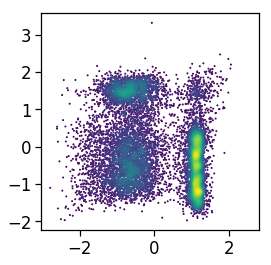

In [26]:
x, y = xs[:, 1], xs[:, 6]
x, y, z = color_density(x, y)
plt.scatter(x, y, c=z, s=1)
plt.axis('square')
pass

In [28]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [29]:
sample = xs

In [30]:
initial_centers = kmeans_plusplus_initializer(sample, 10).initialize()
kmeans_instance = kmeans(sample, initial_centers)
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
centers = kmeans_instance.get_centers()
centers = np.array(centers)

In [31]:
z = np.zeros(10000)
for i, cluster in enumerate(clusters):
    z[cluster] = i

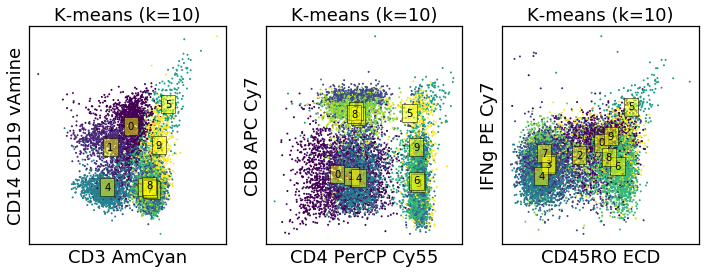

In [32]:
title = 'K-means (k=10)'
fig, axes = plt.subplots(1,3,figsize=(12,4))
dims = [(3,2), (1,6), (8, 10)]
for ax, dim in zip(axes, dims):
    x = xs[:, dim[0]]
    y = xs[:, dim[1]]
    for k, center in enumerate(centers):
        xc = center[dim[0]]
        yc = center[dim[1]]
        ax.text(xc, yc, str(k), 
                va='center', ha='center', 
                bbox=dict(facecolor='yellow', alpha=0.5))
    ax.scatter(x, y, c=z, s=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(markers[dim[0]][1]['PnS'])
    ax.set_ylabel(markers[dim[1]][1]['PnS'])
    ax.set_title(title)

In [33]:
from pyclustering.cluster.kmedoids import kmedoids

In [52]:
from pyclustering.cluster.kmedoids import kmedoids

start_medoids = np.random.randint(0, 10000, 10)
kmedoids_instance = kmedoids(sample, start_medoids)

kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters();

Amount of clusters: 10
Cluster length: 1378
Cluster length: 956
Cluster length: 500
Cluster length: 986
Cluster length: 821
Cluster length: 1163
Cluster length: 1324
Cluster length: 1918
Cluster length: 696
Cluster length: 258


In [56]:
z = np.zeros(10000)
for i, cluster in enumerate(clusters):
    z[cluster] = i

In [59]:
centers = []
for i, cluster in enumerate(clusters):
    centers.append(np.mean(sample[cluster], axis=0))

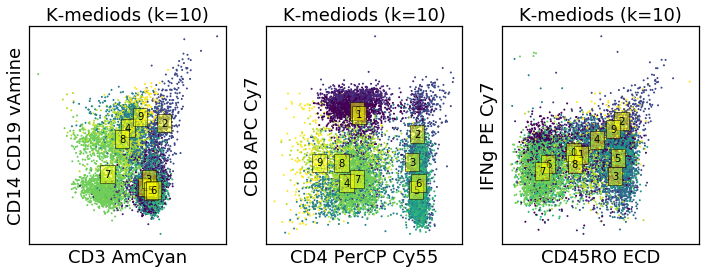

In [61]:
title = 'K-mediods (k=10)'
fig, axes = plt.subplots(1,3,figsize=(12,4))
dims = [(3,2), (1,6), (8, 10)]
for ax, dim in zip(axes, dims):
    x = xs[:, dim[0]]
    y = xs[:, dim[1]]
    for k, center in enumerate(centers):
        xc = center[dim[0]]
        yc = center[dim[1]]
        ax.text(xc, yc, str(k), 
                va='center', ha='center', 
                bbox=dict(facecolor='yellow', alpha=0.5))
    ax.scatter(x, y, c=z, s=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(markers[dim[0]][1]['PnS'])
    ax.set_ylabel(markers[dim[1]][1]['PnS'])
    ax.set_title(title)

In [67]:
import sys
sys.path.append('../FIt-SNE/')
import fast_tsne

In [72]:
res = fast_tsne.fast_tsne(sample)

Text(0.5, 1.0, 't-SNE with K-mediods (k=10)')

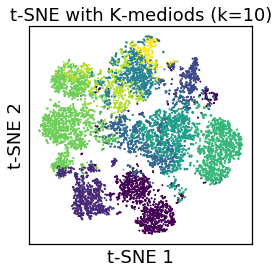

In [83]:
title = 't-SNE with K-mediods (k=10)'
fig, ax = plt.subplots(1,1,figsize=(4,4))
x = res[:,0]
y = res[:, 1]
ax.scatter(x, y, c=z, s=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(title)

In [84]:
from flowsom import flowsom

In [98]:
markers

[('7', {'PnN': 'Blue B-A', 'PnS': 'CD57 FITC'}),
 ('8', {'PnN': 'Blue A-A', 'PnS': 'CD4 PerCP Cy55'}),
 ('9', {'PnN': 'Violet H-A', 'PnS': 'CD14 CD19 vAmine'}),
 ('10', {'PnN': 'Violet G-A', 'PnS': 'CD3 AmCyan'}),
 ('11', {'PnN': 'Red C-A', 'PnS': 'CD27 APC'}),
 ('12', {'PnN': 'Red B-A', 'PnS': 'TNFa A700'}),
 ('13', {'PnN': 'Red A-A', 'PnS': 'CD8 APC Cy7'}),
 ('14', {'PnN': 'Green E-A', 'PnS': 'IL 2 PE'}),
 ('15', {'PnN': 'Green D-A', 'PnS': 'CD45RO ECD'}),
 ('16', {'PnN': 'Green C-A', 'PnS': 'CD107 PE Cy5'}),
 ('17', {'PnN': 'Green A-A', 'PnS': 'IFNg PE Cy7'})]

In [119]:
csv_path = '../data/sample.csv'
df = pd.DataFrame(sample, columns=['_'.join(m[1]['PnS'].split()) for m in markers])
df.to_csv(csv_path, index=False)

In [122]:
! head '../data/sample.csv'

CD57_FITC,CD4_PerCP_Cy55,CD14_CD19_vAmine,CD3_AmCyan,CD27_APC,TNFa_A700,CD8_APC_Cy7,IL_2_PE,CD45RO_ECD,CD107_PE_Cy5,IFNg_PE_Cy7
-0.10142963996825081,1.18926323049145,-0.6792920007862692,0.8935488846174569,1.0138211094258789,-0.12746829508454785,-1.0491984258149996,-0.7401144829130989,-0.7946494938211265,-0.43240762928260906,0.1503169787803049
0.4737799905075588,1.2300573205841627,0.6752231772037348,0.5817595406988822,0.9027212044272809,0.24023633649149972,-0.6543611302197986,1.1029184789808384,-0.16852811816988378,0.17806687099651358,0.3759187045584952
0.678130325559132,-0.4149176706783142,-0.11471774007185365,-2.142024248249953,-0.6722908800896962,-0.307622840680113,-0.4908695768815769,-0.5599184414303136,-0.8975779755910857,-0.6477845153799264,0.17435712562768005
-0.44819216487167224,0.9390462303979732,-0.7586984055099831,-0.12513006359926945,-0.8484096424797861,-1.363767938282052,0.07357535017299106,-0.3862805062244609,1.2657500754787394,-0.9561549873481091,0.6136962754190689
-0.679

In [127]:
tt = flowsom(csv_path, if_fcs=False, if_drop=False)
tt.som_mapping(50, 50, 
                 d=11, 
                 sigma=2.5, 
                 lr=0.1, 
                 batch_size=100,
                 tf_str=None)
tt.meta_clustering(flowsom.AgglomerativeClustering,
                     min_n=40, 
                     max_n=45, 
                     iter_n=3) 

/usr/local/lib/python3.7/site-packages/flowsom/flowsomtool.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.tf_matrix = self.df.as_matrix()


Training...
 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.5803192898404083
 topographic error: 0.0097

...ready!


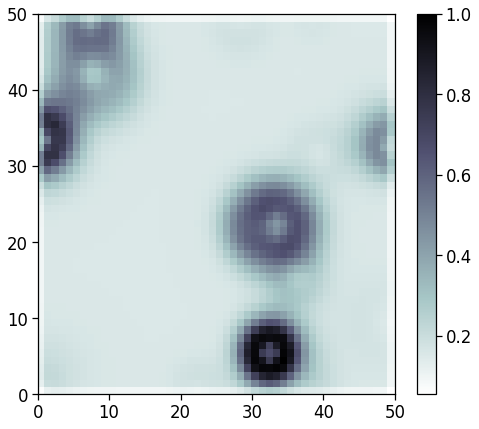

In [129]:
som_output_weights = tt.map_som 
som_distance_map = tt.map_som.distance_map() #

plt.figure(figsize=(8, 7))
plt.pcolor(som_distance_map, cmap='bone_r')
plt.colorbar()
pass

In [130]:
tt.meta_clustering(flowsom.AgglomerativeClustering, #  cluster_class: e.g. KMeans, a cluster class, like "from sklearn.cluster import KMeans"
                   8, # min_n: e.g. 10, the min proposed number of clusters
                   25, # max_n: e.g. 31, the max proposed number of clusters
                   3, # iter_n: e.g 10, the iteration times for each number of clusters
                   resample_proportion=0.6, # resample_proportion: e.g 0.6, the proportion of re-sampling when computing clustering
                   verbose=True #verbose: e.g. False, whether print out the clustering process
                  )

At k = 8, aka. iteration = 0
	At resampling h = 0, (k = 8)
	At resampling h = 1, (k = 8)
	At resampling h = 2, (k = 8)
At k = 9, aka. iteration = 1
	At resampling h = 0, (k = 9)
	At resampling h = 1, (k = 9)
	At resampling h = 2, (k = 9)
At k = 10, aka. iteration = 2
	At resampling h = 0, (k = 10)
	At resampling h = 1, (k = 10)
	At resampling h = 2, (k = 10)
At k = 11, aka. iteration = 3
	At resampling h = 0, (k = 11)
	At resampling h = 1, (k = 11)
	At resampling h = 2, (k = 11)
At k = 12, aka. iteration = 4
	At resampling h = 0, (k = 12)
	At resampling h = 1, (k = 12)
	At resampling h = 2, (k = 12)
At k = 13, aka. iteration = 5
	At resampling h = 0, (k = 13)
	At resampling h = 1, (k = 13)
	At resampling h = 2, (k = 13)
At k = 14, aka. iteration = 6
	At resampling h = 0, (k = 14)
	At resampling h = 1, (k = 14)
	At resampling h = 2, (k = 14)
At k = 15, aka. iteration = 7
	At resampling h = 0, (k = 15)
	At resampling h = 1, (k = 15)
	At resampling h = 2, (k = 15)
At k = 16, aka. iteratio

In [131]:
tt.bestk

9

9


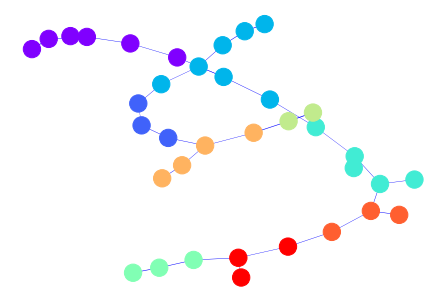

In [134]:
tt.vis(t=4, # the number of total nodes = t * bestk
       edge_color='b', 
       node_size=300, 
       with_labels=False)

In [139]:
tt.labeling()
output_df = tt.df # new column added: category

0 samples done...


In [141]:
output_df.head(3)

CD57_FITC  CD4_PerCP_Cy55  CD14_CD19_vAmine  CD3_AmCyan  CD27_APC  \
0   -0.10143        1.189263         -0.679292    0.893549  1.013821   
1    0.47378        1.230057          0.675223    0.581760  0.902721   
2    0.67813       -0.414918         -0.114718   -2.142024 -0.672291   

   TNFa_A700  CD8_APC_Cy7   IL_2_PE  CD45RO_ECD  CD107_PE_Cy5  IFNg_PE_Cy7  \
0  -0.127468    -1.049198 -0.740114   -0.794649     -0.432408     0.150317   
1   0.240236    -0.654361  1.102918   -0.168528      0.178067     0.375919   
2  -0.307623    -0.490870 -0.559918   -0.897578     -0.647785     0.174357   

   category  
0         4  
1         0  
2         2

In [152]:
mmm = output_df.groupby(['category']).mean()

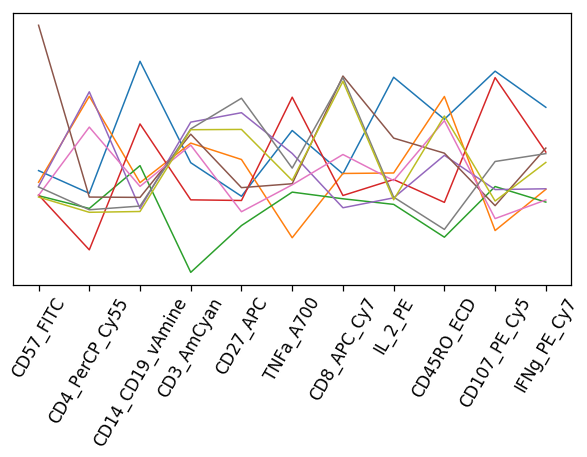

In [153]:
plt.figure(figsize=(10,5))
x = [i for i in range(11)]
my_xticks = mmm.columns
plt.xticks(x, my_xticks)
for i in range(len(mmm)):
    plt.plot(x, mmm.iloc[i])
plt.xticks(rotation=60)
plt.yticks([])
pass

In [155]:
output_df.columns

Index(['CD57_FITC', 'CD4_PerCP_Cy55', 'CD14_CD19_vAmine', 'CD3_AmCyan',
       'CD27_APC', 'TNFa_A700', 'CD8_APC_Cy7', 'IL_2_PE', 'CD45RO_ECD',
       'CD107_PE_Cy5', 'IFNg_PE_Cy7', 'category'],
      dtype='object')

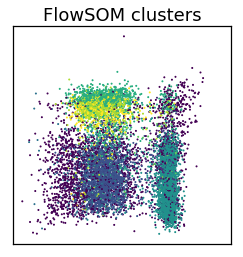

In [160]:
plt.scatter(
    output_df['CD4_PerCP_Cy55'], 
    output_df['CD8_APC_Cy7'], 
    s = 1,
    c = output_df['category']
)
plt.xticks([])
plt.yticks([])
plt.axis('square')
plt.title('FlowSOM clusters')
pass